In [66]:
import pandas as pd
df = pd.read_parquet("data/train_student.parquet")
len(df)

2048

In [67]:
import json
selected_samples = []
all_data = []
with open("data/train_student_42step_32B_teacher_logprobs.jsonl", "r") as f:
    for line in f:
        data = json.loads(line)
        # all_data.append(data)
        # print(json.dumps(data, indent=4))
        if data['answer'] in data['turn_logprobs'][-1]['raw_content']:
            all_data.append(data)
            # print(data['turn_logprobs'][-1]['raw_content'])
            # break
            continue
        all_data.append(data)

        index = data.get("index", -1)
        selected_samples.append(df.loc[index])


In [68]:
selected_samples[-20].to_dict(),all_data[-20]
len(all_data)

1497

In [69]:
import json
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# For Jupyter inline plotting
%matplotlib inline

# Set figure style
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (14, 10)

In [ ]:
def load_disagreement_scores(jsonl_file):
    """Load JSONL file and extract disagreement scores"""
    
    all_scores = []
    sample_max_scores = []
    sample_avg_scores = []
    turn_idx_scores = defaultdict(list)
    sample_info = []
    
    with open(jsonl_file, 'r', encoding='utf-8') as f:
        for line_num, line in enumerate(f, 1):
            line = line.strip()
            if not line:
                continue
            
            try:
                data = json.loads(line)
                if data['answer'].lower() in data['turn_logprobs'][-1]['raw_content'].lower():
                    continue
                turn_logprobs = data.get("turn_logprobs", [])
                
                sample_scores = []
                for turn in turn_logprobs:
                    if "disagreement_score" in turn and "error" not in turn:
                        score = turn["disagreement_score"]
                        all_scores.append(score)
                        sample_scores.append(score)
                        
                        turn_idx = turn.get("turn_idx", -1)
                        turn_idx_scores[turn_idx].append(score)
                
                if sample_scores:
                    sample_max_scores.append(max(sample_scores))
                    sample_avg_scores.append(np.mean(sample_scores))
                    sample_info.append({
                        'index': data.get('index', -1),
                        'max_score': max(sample_scores),
                        'avg_score': np.mean(sample_scores),
                        'num_turns': len(sample_scores)
                    })
            except Exception as e:
                print(f"Error on line {line_num}: {e}")
                continue
    
    return {
        "all_scores": np.array(all_scores),
        "sample_max_scores": np.array(sample_max_scores),
        "sample_avg_scores": np.array(sample_avg_scores),
        "turn_idx_scores": turn_idx_scores,
        "sample_info": sample_info
    }

# Load data
jsonl_file = "/root/yuxiang/verl/baseline/preliminary/data/train_student_42step_32B_teacher_logprobs.jsonl"
data = load_disagreement_scores(jsonl_file)

print(f"✓ Data loaded successfully!")
print(f"  Total turns: {len(data['all_scores'])}")
print(f"  Total samples: {len(data['sample_max_scores'])}")

✓ Data loaded successfully!
  Total turns: 2426
  Total samples: 548


In [71]:
# def load_disagreement_scores(jsonl_file):
#     """Load JSONL file and extract disagreement scores"""
    
#     all_scores = []
#     sample_max_scores = []
#     sample_avg_scores = []
#     turn_idx_scores = defaultdict(list)
#     sample_info = []
    
#     with open(jsonl_file, 'r', encoding='utf-8') as f:
#         for line_num, line in enumerate(f, 1):
#             line = line.strip()
#             if not line:
#                 continue
            
#             try:
#                 data = json.loads(line)
#                 turn_logprobs = data.get("turn_logprobs", [])
                
#                 sample_scores = []
#                 for turn in turn_logprobs:
#                     if "disagreement_score" in turn and "error" not in turn:
#                         score = turn["disagreement_score"]
#                         all_scores.append(score)
#                         sample_scores.append(score)
                        
#                         turn_idx = turn.get("turn_idx", -1)
#                         turn_idx_scores[turn_idx].append(score)
                
#                 if sample_scores:
#                     sample_max_scores.append(max(sample_scores))
#                     sample_avg_scores.append(np.mean(sample_scores))
#                     sample_info.append({
#                         'index': data.get('index', -1),
#                         'max_score': max(sample_scores),
#                         'avg_score': np.mean(sample_scores),
#                         'num_turns': len(sample_scores)
#                     })
#             except Exception as e:
#                 print(f"Error on line {line_num}: {e}")
#                 continue
    
#     return {
#         "all_scores": np.array(all_scores),
#         "sample_max_scores": np.array(sample_max_scores),
#         "sample_avg_scores": np.array(sample_avg_scores),
#         "turn_idx_scores": turn_idx_scores,
#         "sample_info": sample_info
#     }

# # Load data
# jsonl_file = "/root/yuxiang/verl/baseline/preliminary/data/train_student_42step_32B_teacher_logprobs_high_disagreement_samples.jsonl"
# data = load_disagreement_scores(jsonl_file)

# print(f"✓ Data loaded successfully!")
# print(f"  Total turns: {len(data['all_scores'])}")
# print(f"  Total samples: {len(data['sample_max_scores'])}")

In [72]:
all_scores = data['all_scores']
sample_max_scores = data['sample_max_scores']

print("=" * 70)
print("DISAGREEMENT SCORE STATISTICS - ALL TURNS")
print("=" * 70)
print(f"Total turns: {len(all_scores)}")
print(f"Mean:        {np.mean(all_scores):.4f}")
print(f"Median:      {np.median(all_scores):.4f}")
print(f"Std Dev:     {np.std(all_scores):.4f}")
print(f"Min:         {np.min(all_scores):.4f}")
print(f"Max:         {np.max(all_scores):.4f}")

print(f"\nPercentiles:")
for p in [10, 25, 50, 75, 90, 95, 99]:
    print(f"  {p:2d}%: {np.percentile(all_scores, p):.4f}")

print(f"\nPercentage above thresholds:")
for threshold in [0.1, 0.2, 0.3, 0.4, 0.5]:
    count = (all_scores > threshold).sum()
    ratio = count / len(all_scores) * 100
    print(f"  > {threshold}: {count:4d} turns ({ratio:.2f}%)")

print("\n" + "=" * 70)
print("DISAGREEMENT SCORE STATISTICS - MAX PER SAMPLE")
print("=" * 70)
print(f"Total samples: {len(sample_max_scores)}")
print(f"Mean:          {np.mean(sample_max_scores):.4f}")
print(f"Median:        {np.median(sample_max_scores):.4f}")
print(f"Std Dev:       {np.std(sample_max_scores):.4f}")
print(f"Min:           {np.min(sample_max_scores):.4f}")
print(f"Max:           {np.max(sample_max_scores):.4f}")

DISAGREEMENT SCORE STATISTICS - ALL TURNS
Total turns: 2426
Mean:        0.1028
Median:      0.0995
Std Dev:     0.0505
Min:         -0.0625
Max:         0.3366

Percentiles:
  10%: 0.0422
  25%: 0.0678
  50%: 0.0995
  75%: 0.1342
  90%: 0.1670
  95%: 0.1882
  99%: 0.2451

Percentage above thresholds:
  > 0.1: 1206 turns (49.71%)
  > 0.2:   87 turns (3.59%)
  > 0.3:    4 turns (0.16%)
  > 0.4:    0 turns (0.00%)
  > 0.5:    0 turns (0.00%)

DISAGREEMENT SCORE STATISTICS - MAX PER SAMPLE
Total samples: 548
Mean:          0.1559
Median:        0.1517
Std Dev:       0.0445
Min:           0.0489
Max:           0.3366


In [73]:
turn_idx_scores = data['turn_idx_scores']

print("=" * 70)
print("STATISTICS BY TURN INDEX")
print("=" * 70)

for turn_idx in sorted(turn_idx_scores.keys()):
    scores = np.array(turn_idx_scores[turn_idx])
    above_02 = (scores > 0.2).sum()
    above_03 = (scores > 0.3).sum()
    
    print(f"\nTurn {turn_idx} (n={len(scores)}):")
    print(f"  Mean:     {np.mean(scores):.4f}")
    print(f"  Median:   {np.median(scores):.4f}")
    print(f"  Std Dev:  {np.std(scores):.4f}")
    print(f"  > 0.2:    {above_02} ({above_02/len(scores)*100:.1f}%)")
    print(f"  > 0.3:    {above_03} ({above_03/len(scores)*100:.1f}%)")

STATISTICS BY TURN INDEX

Turn 0 (n=548):
  Mean:     0.1333
  Median:   0.1310
  Std Dev:  0.0436
  > 0.2:    40 (7.3%)
  > 0.3:    0 (0.0%)

Turn 1 (n=548):
  Mean:     0.0892
  Median:   0.0810
  Std Dev:  0.0547
  > 0.2:    16 (2.9%)
  > 0.3:    3 (0.5%)

Turn 2 (n=527):
  Mean:     0.0958
  Median:   0.0914
  Std Dev:  0.0526
  > 0.2:    21 (4.0%)
  > 0.3:    0 (0.0%)

Turn 3 (n=304):
  Mean:     0.0956
  Median:   0.0951
  Std Dev:  0.0410
  > 0.2:    3 (1.0%)
  > 0.3:    0 (0.0%)

Turn 4 (n=195):
  Mean:     0.1003
  Median:   0.0939
  Std Dev:  0.0448
  > 0.2:    4 (2.1%)
  > 0.3:    1 (0.5%)

Turn 5 (n=124):
  Mean:     0.0919
  Median:   0.0906
  Std Dev:  0.0373
  > 0.2:    1 (0.8%)
  > 0.3:    0 (0.0%)

Turn 6 (n=71):
  Mean:     0.0997
  Median:   0.0940
  Std Dev:  0.0424
  > 0.2:    2 (2.8%)
  > 0.3:    0 (0.0%)

Turn 7 (n=37):
  Mean:     0.0855
  Median:   0.0909
  Std Dev:  0.0363
  > 0.2:    0 (0.0%)
  > 0.3:    0 (0.0%)

Turn 8 (n=24):
  Mean:     0.0917
  Median:  

/tmp/ipykernel_456063/4077122993.py:32: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[1, 0].boxplot(turn_data, labels=[f'T{idx}' for idx in turn_indices], patch_artist=True)


✓ Plot saved as: disagreement_score_distribution.png


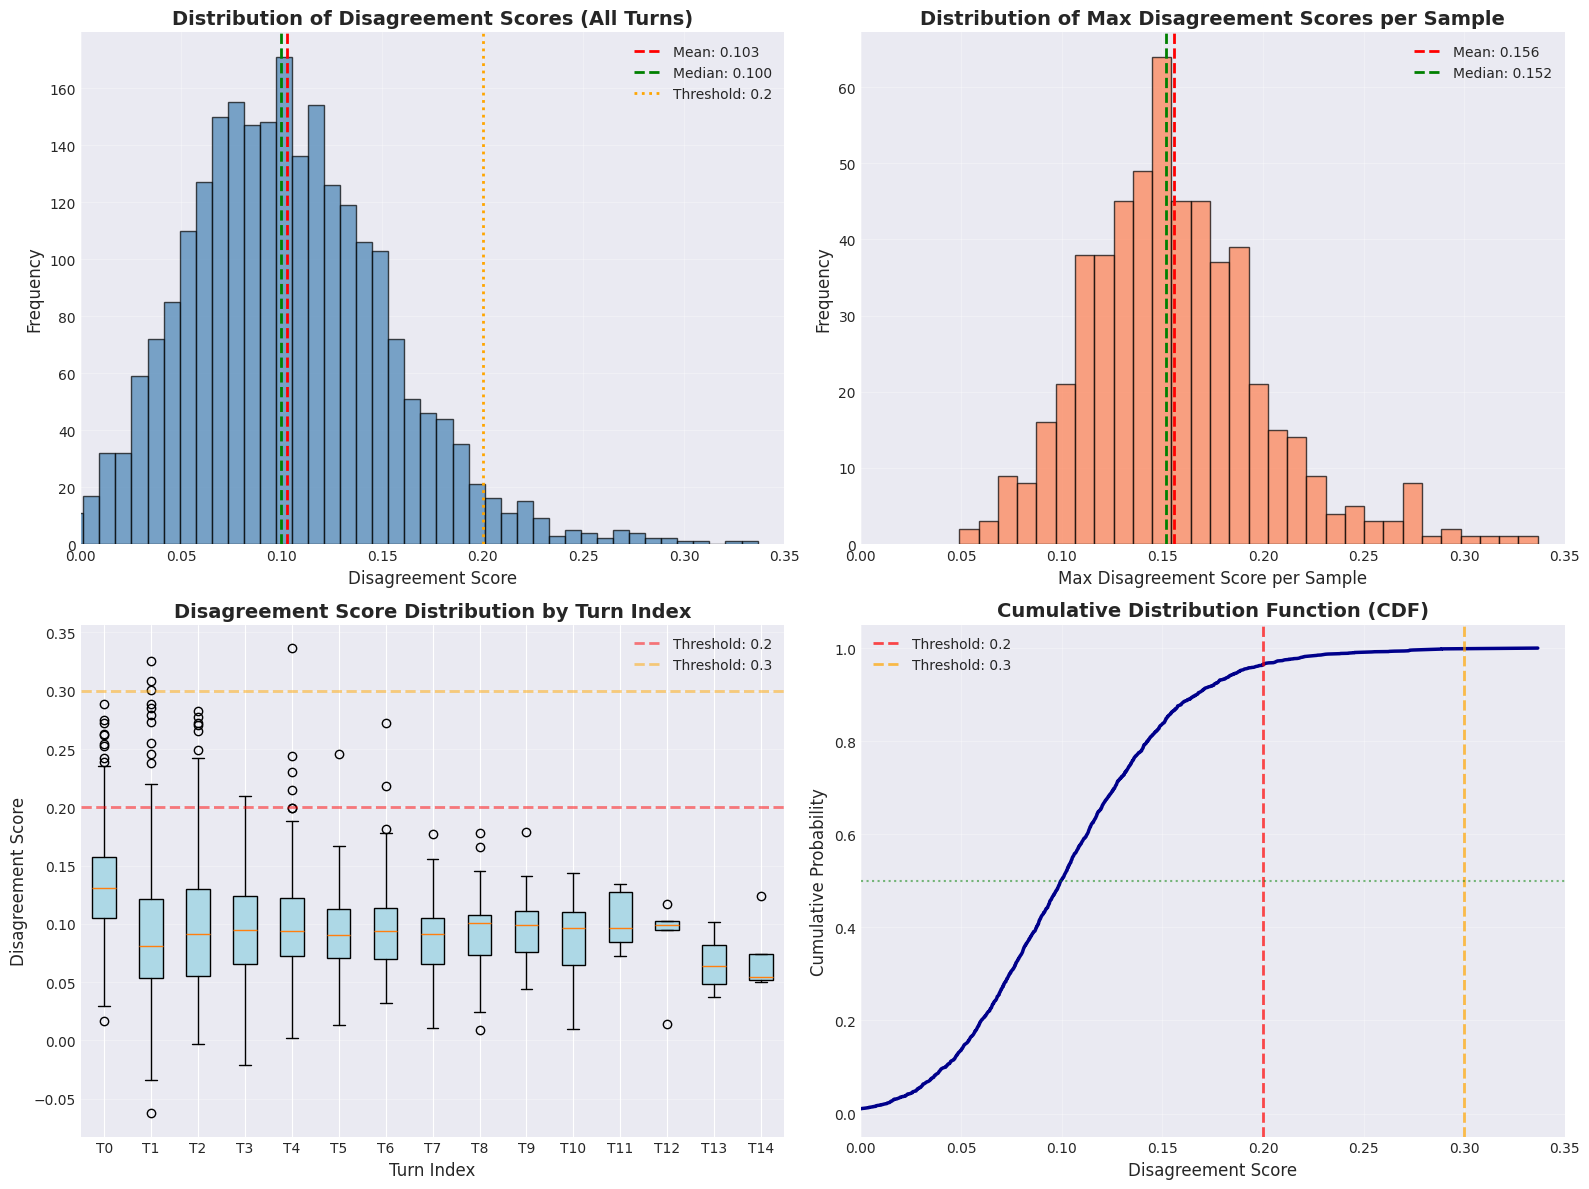

In [77]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Histogram of all scores
axes[0, 0].hist(all_scores, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0, 0].axvline(np.mean(all_scores), color='red', linestyle='--', linewidth=2,
                   label=f'Mean: {np.mean(all_scores):.3f}')
axes[0, 0].axvline(np.median(all_scores), color='green', linestyle='--', linewidth=2,
                   label=f'Median: {np.median(all_scores):.3f}')
axes[0, 0].axvline(0.2, color='orange', linestyle=':', linewidth=2,
                   label='Threshold: 0.2')
axes[0, 0].set_xlabel('Disagreement Score', fontsize=12)
axes[0, 0].set_ylabel('Frequency', fontsize=12)
axes[0, 0].set_title('Distribution of Disagreement Scores (All Turns)', fontsize=14, fontweight='bold')
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(True, alpha=0.3)

# 2. Histogram of max scores per sample
axes[0, 1].hist(sample_max_scores, bins=30, edgecolor='black', alpha=0.7, color='coral')
axes[0, 1].axvline(np.mean(sample_max_scores), color='red', linestyle='--', linewidth=2,
                   label=f'Mean: {np.mean(sample_max_scores):.3f}')
axes[0, 1].axvline(np.median(sample_max_scores), color='green', linestyle='--', linewidth=2,
                   label=f'Median: {np.median(sample_max_scores):.3f}')
axes[0, 1].set_xlabel('Max Disagreement Score per Sample', fontsize=12)
axes[0, 1].set_ylabel('Frequency', fontsize=12)
axes[0, 1].set_title('Distribution of Max Disagreement Scores per Sample', fontsize=14, fontweight='bold')
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(True, alpha=0.3)

# 3. Box plot by turn index
turn_indices = sorted(turn_idx_scores.keys())
turn_data = [turn_idx_scores[idx] for idx in turn_indices]
bp = axes[1, 0].boxplot(turn_data, labels=[f'T{idx}' for idx in turn_indices], patch_artist=True)
for patch in bp['boxes']:
    patch.set_facecolor('lightblue')
axes[1, 0].set_xlabel('Turn Index', fontsize=12)
axes[1, 0].set_ylabel('Disagreement Score', fontsize=12)
axes[1, 0].set_title('Disagreement Score Distribution by Turn Index', fontsize=14, fontweight='bold')
axes[1, 0].axhline(0.2, color='red', linestyle='--', alpha=0.5, linewidth=2, label='Threshold: 0.2')
axes[1, 0].axhline(0.3, color='orange', linestyle='--', alpha=0.5, linewidth=2, label='Threshold: 0.3')
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(True, alpha=0.3, axis='y')

# 4. Cumulative Distribution Function (CDF)
sorted_scores = np.sort(all_scores)
cdf = np.arange(1, len(sorted_scores) + 1) / len(sorted_scores)
axes[1, 1].plot(sorted_scores, cdf, linewidth=2.5, color='darkblue')
axes[1, 1].axvline(0.2, color='red', linestyle='--', alpha=0.7, linewidth=2, label='Threshold: 0.2')
axes[1, 1].axvline(0.3, color='orange', linestyle='--', alpha=0.7, linewidth=2, label='Threshold: 0.3')
axes[1, 1].axhline(0.5, color='green', linestyle=':', alpha=0.5, linewidth=1.5)
axes[1, 1].set_xlabel('Disagreement Score', fontsize=12)
axes[1, 1].set_ylabel('Cumulative Probability', fontsize=12)
axes[1, 1].set_title('Cumulative Distribution Function (CDF)', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].legend(fontsize=10)

axes[0, 0].set_xlim(0, 0.35)  # 添加这一行
axes[0, 1].set_xlim(0, 0.35)  # 添加这一行
axes[1, 1].set_xlim(0, 0.35)
plt.tight_layout()
plt.savefig('disagreement_score_distribution.png', dpi=300, bbox_inches='tight')
print("✓ Plot saved as: disagreement_score_distribution.png")
plt.show()

In [75]:
# Sort samples by max score
sorted_samples = sorted(data['sample_info'], key=lambda x: x['max_score'], reverse=True)

print("=" * 70)
print("TOP 10 SAMPLES WITH HIGHEST MAX DISAGREEMENT SCORES")
print("=" * 70)
print(f"{'Rank':<6} {'Index':<8} {'Max Score':<12} {'Avg Score':<12} {'# Turns':<8}")
print("-" * 70)

for rank, sample in enumerate(sorted_samples[:10], 1):
    print(f"{rank:<6} {sample['index']:<8} {sample['max_score']:<12.4f} "
          f"{sample['avg_score']:<12.4f} {sample['num_turns']:<8}")

TOP 10 SAMPLES WITH HIGHEST MAX DISAGREEMENT SCORES
Rank   Index    Max Score    Avg Score    # Turns 
----------------------------------------------------------------------
1      957      0.3366       0.1743       8       
2      1335     0.3252       0.1727       8       
3      772      0.3084       0.1486       7       
4      144      0.3010       0.1185       8       
5      714      0.2889       0.1307       4       
6      1457     0.2889       0.1840       3       
7      402      0.2853       0.2105       3       
8      663      0.2789       0.1651       3       
9      735      0.2773       0.1113       6       
10     783      0.2745       0.1353       3       


✓ Plot saved as: max_disagreement_score_per_sample.png


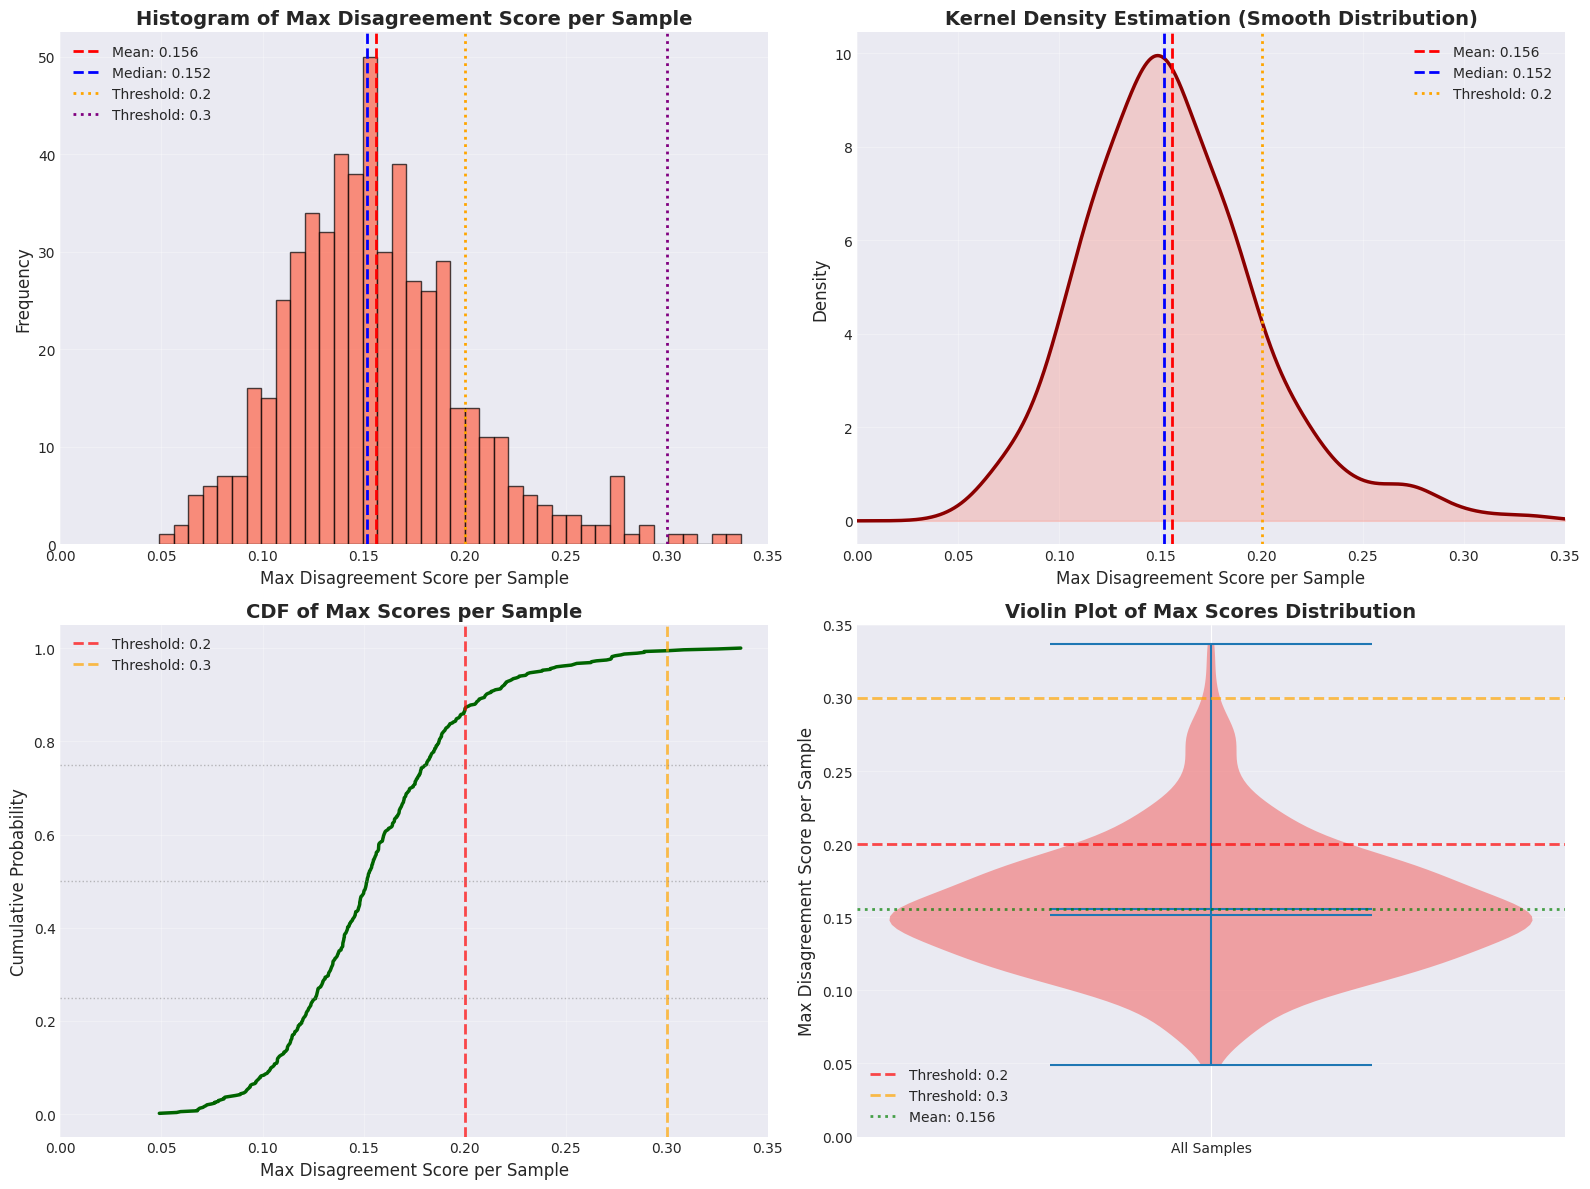


DETAILED STATISTICS - MAX DISAGREEMENT SCORE PER SAMPLE
Total samples: 548

Central Tendency:
  Mean:          0.1559
  Median:        0.1517
  Mode (approx): 0.1500

Spread:
  Std Dev:       0.0445
  Variance:      0.0020
  IQR:           0.0548
  Range:         0.2877

Percentiles:
   5%: 0.0922
  10%: 0.1049
  25%: 0.1263
  50%: 0.1517
  75%: 0.1811
  90%: 0.2107
  95%: 0.2372

Threshold Analysis:
  Samples with max score > 0.15: 289 (52.7%)
  Samples with max score > 0.2:  75 (13.7%)
  Samples with max score > 0.25:  21 (3.8%)
  Samples with max score > 0.3:   4 (0.7%)
  Samples with max score > 0.35:   0 (0.0%)


In [78]:
# Create detailed visualization for max disagreement score per sample
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Histogram with more bins and details
axes[0, 0].hist(sample_max_scores, bins=40, edgecolor='black', alpha=0.7, color='tomato')
axes[0, 0].axvline(np.mean(sample_max_scores), color='red', linestyle='--', linewidth=2,
                   label=f'Mean: {np.mean(sample_max_scores):.3f}')
axes[0, 0].axvline(np.median(sample_max_scores), color='blue', linestyle='--', linewidth=2,
                   label=f'Median: {np.median(sample_max_scores):.3f}')
axes[0, 0].axvline(0.2, color='orange', linestyle=':', linewidth=2, label='Threshold: 0.2')
axes[0, 0].axvline(0.3, color='purple', linestyle=':', linewidth=2, label='Threshold: 0.3')
axes[0, 0].set_xlabel('Max Disagreement Score per Sample', fontsize=12)
axes[0, 0].set_ylabel('Frequency', fontsize=12)
axes[0, 0].set_title('Histogram of Max Disagreement Score per Sample', fontsize=14, fontweight='bold')
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_xlim(0, 0.35)

# 2. Kernel Density Estimation (KDE) - Smooth distribution
from scipy import stats
kde = stats.gaussian_kde(sample_max_scores)
x_range = np.linspace(0, 0.35, 1000)
density = kde(x_range)
axes[0, 1].plot(x_range, density, linewidth=2.5, color='darkred')
axes[0, 1].fill_between(x_range, density, alpha=0.3, color='salmon')
axes[0, 1].axvline(np.mean(sample_max_scores), color='red', linestyle='--', linewidth=2,
                   label=f'Mean: {np.mean(sample_max_scores):.3f}')
axes[0, 1].axvline(np.median(sample_max_scores), color='blue', linestyle='--', linewidth=2,
                   label=f'Median: {np.median(sample_max_scores):.3f}')
axes[0, 1].axvline(0.2, color='orange', linestyle=':', linewidth=2, label='Threshold: 0.2')
axes[0, 1].set_xlabel('Max Disagreement Score per Sample', fontsize=12)
axes[0, 1].set_ylabel('Density', fontsize=12)
axes[0, 1].set_title('Kernel Density Estimation (Smooth Distribution)', fontsize=14, fontweight='bold')
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_xlim(0, 0.35)

# 3. Cumulative Distribution Function
sorted_max_scores = np.sort(sample_max_scores)
cdf_max = np.arange(1, len(sorted_max_scores) + 1) / len(sorted_max_scores)
axes[1, 0].plot(sorted_max_scores, cdf_max, linewidth=2.5, color='darkgreen')
axes[1, 0].axvline(0.2, color='red', linestyle='--', alpha=0.7, linewidth=2, label='Threshold: 0.2')
axes[1, 0].axvline(0.3, color='orange', linestyle='--', alpha=0.7, linewidth=2, label='Threshold: 0.3')
axes[1, 0].axhline(0.25, color='gray', linestyle=':', alpha=0.5, linewidth=1)
axes[1, 0].axhline(0.5, color='gray', linestyle=':', alpha=0.5, linewidth=1)
axes[1, 0].axhline(0.75, color='gray', linestyle=':', alpha=0.5, linewidth=1)
axes[1, 0].set_xlabel('Max Disagreement Score per Sample', fontsize=12)
axes[1, 0].set_ylabel('Cumulative Probability', fontsize=12)
axes[1, 0].set_title('CDF of Max Scores per Sample', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].legend(fontsize=10)
axes[1, 0].set_xlim(0, 0.35)

# 4. Box plot with violin overlay
parts = axes[1, 1].violinplot([sample_max_scores], positions=[1], widths=0.7,
                               showmeans=True, showmedians=True)
for pc in parts['bodies']:
    pc.set_facecolor('lightcoral')
    pc.set_alpha(0.7)

# Add threshold lines
axes[1, 1].axhline(0.2, color='red', linestyle='--', alpha=0.7, linewidth=2, label='Threshold: 0.2')
axes[1, 1].axhline(0.3, color='orange', linestyle='--', alpha=0.7, linewidth=2, label='Threshold: 0.3')
axes[1, 1].axhline(np.mean(sample_max_scores), color='green', linestyle=':', alpha=0.7, 
                   linewidth=2, label=f'Mean: {np.mean(sample_max_scores):.3f}')

axes[1, 1].set_ylabel('Max Disagreement Score per Sample', fontsize=12)
axes[1, 1].set_title('Violin Plot of Max Scores Distribution', fontsize=14, fontweight='bold')
axes[1, 1].set_xticks([1])
axes[1, 1].set_xticklabels(['All Samples'])
axes[1, 1].legend(fontsize=10)
axes[1, 1].grid(True, alpha=0.3, axis='y')
axes[1, 1].set_ylim(0, 0.35)

plt.tight_layout()
plt.savefig('max_disagreement_score_per_sample.png', dpi=300, bbox_inches='tight')
print("✓ Plot saved as: max_disagreement_score_per_sample.png")
plt.show()

# Print detailed statistics
print("\n" + "=" * 70)
print("DETAILED STATISTICS - MAX DISAGREEMENT SCORE PER SAMPLE")
print("=" * 70)
print(f"Total samples: {len(sample_max_scores)}")
print(f"\nCentral Tendency:")
print(f"  Mean:          {np.mean(sample_max_scores):.4f}")
print(f"  Median:        {np.median(sample_max_scores):.4f}")
print(f"  Mode (approx): {stats.mode(np.round(sample_max_scores, 2), keepdims=True).mode[0]:.4f}")
print(f"\nSpread:")
print(f"  Std Dev:       {np.std(sample_max_scores):.4f}")
print(f"  Variance:      {np.var(sample_max_scores):.4f}")
print(f"  IQR:           {np.percentile(sample_max_scores, 75) - np.percentile(sample_max_scores, 25):.4f}")
print(f"  Range:         {np.max(sample_max_scores) - np.min(sample_max_scores):.4f}")
print(f"\nPercentiles:")
for p in [5, 10, 25, 50, 75, 90, 95]:
    print(f"  {p:2d}%: {np.percentile(sample_max_scores, p):.4f}")
print(f"\nThreshold Analysis:")
for threshold in [0.15, 0.2, 0.25, 0.3, 0.35]:
    count = (sample_max_scores > threshold).sum()
    ratio = count / len(sample_max_scores) * 100
    print(f"  Samples with max score > {threshold}: {count:3d} ({ratio:.1f}%)")